<a href="https://colab.research.google.com/github/g00dAA/Game-Recommendation-System-Big-Data-Project-/blob/main/game_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction

**Exploratory Data Analysis and Game Recommendation System on Steam Store Dataset
**

The dataset used in this notebook comprises a rich collection of over 41 million user recommendations and detailed information about games and add-ons available on the Steam Store. Steam, a leading online platform for purchasing and downloading video games, provides a diverse range of gaming-related content. The dataset is divided into three main entities:


<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*KruicYPp0frLCK0htff59g.png" width = 400px align="right"/>



![steam-logo-download-compress.gif](attachment:c9636e66-bc80-4387-a034-1b98c0a85790.gif)

*[Steam artwork](https://steamcommunity.com/sharedfiles/filedetails/?id=1433659453) by [GeneralDotV2](https://steamcommunity.com/id/GeneralDotV2)*

# 1.0 Imports

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, split, col
import plotly.express as px
from pyspark.sql.functions import count, col
from pyspark.sql.functions import col, length
from pyspark.sql.functions import col, explode, split, avg
import seaborn as sns
from pyspark.sql.functions import col, year
from pyspark.sql.functions import col, year, to_date
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, log
from pyspark.sql.functions import corr
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, explode, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import unix_timestamp, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# 2.0 Read dataset

In [ ]:
spark = SparkSession.builder.appName("AnimeAnalysis").getOrCreate()

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d antonkozyriev/game-recommendations-on-steam
! mkdir comp_data
! unzip /content/game-recommendations-on-steam.zip -d comp_data

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                          title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                   Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           1796         36  1.0              
marouandaghmoumi/dropout-and-success-student-data-analysis   Dropout and Success: Student Data Analysis   87KB  2023-12-31 15:44:56           1352         34  1.0              
thedrcat/daigt-v2-train-dataset                              DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           3460        280  1.0              
risakashiwabara/n

In [ ]:
recommendation_df = spark.read.csv("/content/comp_data/recommendations.csv", header=True, inferSchema=True)
users_df = spark.read.csv("/content/comp_data/users.csv", header=True, inferSchema=True)
games_df = spark.read.csv("/content/comp_data/games.csv", header=True, inferSchema=True)

In [ ]:
json_file_path = "/content/comp_data/games_metadata.json"

# Read the JSON file
metadata_df = spark.read.json(json_file_path, multiLine=False)

# Show the DataFrame schema to verify it's loaded correctly
metadata_df.printSchema()

root
 |-- app_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
metadata_df.show(3)

+------+--------------------+--------------------+
|app_id|         description|                tags|
+------+--------------------+--------------------+
| 13500|Enter the dark un...|[Action, Adventur...|
| 22364|                    |            [Action]|
|113020|Monaco: What's Yo...|[Co-op, Stealth, ...|
+------+--------------------+--------------------+
only showing top 3 rows



# 3.0 Explore dataset

In [ ]:
Directorio = '/content/comp_data/'

games = pd.read_csv(Directorio + 'games.csv')
reco = pd.read_csv(Directorio + 'recommendations.csv')
metadata = pd.read_json(Directorio + 'games_metadata.json', lines=True)
users = pd.read_csv(Directorio+'users.csv')
def perc_na(df: pd.DataFrame) -> float:
    """Calculates a percentage of missing values in the dataframe."""
    return np.count_nonzero(df.isnull().values) / (df.shape[0] * df.shape[1]) * 100.0


pd.DataFrame([
    ["Recommendations", perc_na(reco)],
    ["Users", perc_na(users)],
    ["Games", perc_na(games)],
    ["Metadata",perc_na(metadata)]
], columns=["Dataframe", "% of missing values"])

,Dataframe,% of missing values
0,Recommendations,0.0
1,Users,0.0
2,Games,0.0
3,Metadata,0.0


In [ ]:
metadata_df.show()

+------+--------------------+--------------------+
|app_id|         description|                tags|
+------+--------------------+--------------------+
| 13500|Enter the dark un...|[Action, Adventur...|
| 22364|                    |            [Action]|
|113020|Monaco: What's Yo...|[Co-op, Stealth, ...|
|226560|Escape Dead Islan...|[Zombies, Adventu...|
|249050|Dungeon of the En...|[Roguelike, Strat...|
|250180|“METAL SLUG 3”, t...|[Arcade, Classic,...|
|253980|Experience incred...|[RPG, Action, Fan...|
|271850|                    |[Strategy, Simula...|
|282900|Packed with fast-...|[Anime, JRPG, Fem...|
| 19810|Lead a team of do...|  [Action, Tactical]|
| 15270|In a ferocious Ar...|[Horror, Action, ...|
| 21130|Build the adventu...|[LEGO, Adventure,...|
| 22130|Includes Hearts o...|[Strategy, Grand ...|
| 29180|Enter the ambient...|[Indie, Casual, P...|
| 32750|The best-selling ...|[Action, Simulati...|
|241620|Action-oriented c...|[RPG, Indie, Isom...|
|408520|Enter a surreal a...|[A

## 3.1 games df

In [ ]:
games_df.show()

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 13500|Prince of Persia:...|  2008-11-21|true|false|false|  Very Positive|            84|        2199|       9.99|          9.99|     0.0|      true|
| 22364|BRINK: Agents of ...|  2011-08-03|true|false|false|       Positive|            85|          21|       2.99|          2.99|     0.0|      true|
|113020|Monaco: What's Yo...|  2013-04-24|true| true| true|  Very Positive|            92|        3722|      14.99|         14.99|     0.0|      true|
|226560|  Escape Dead Island|  2014-11-18|true|false|false|          Mixed|            61|    

In [ ]:
games_df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)



### 3.1.1 Missing values

In [ ]:
for column in games_df.columns:
    missing_count = games_df.filter(col(column).isNull()).count()
    print(f"Missing values in {column}: {missing_count}")

Missing values in app_id: 0
Missing values in title: 0
Missing values in date_release: 0
Missing values in win: 0
Missing values in mac: 0
Missing values in linux: 0
Missing values in rating: 0
Missing values in positive_ratio: 0
Missing values in user_reviews: 0
Missing values in price_final: 0
Missing values in price_original: 0
Missing values in discount: 0
Missing values in steam_deck: 0


There is no missing values here, which is great

### 3.1.2 Distribution of Numerical Columns

**positive_ratio**: Ratio of positive feedbacks

**user_reviews**: Amount of user reviews availble on the Steam page

**price_final**: Price in US dollars $ calculated after the discount

**price_original**: Price in US dollars $ before the discount

**discount**: Discount percentage


**positive_ratio**

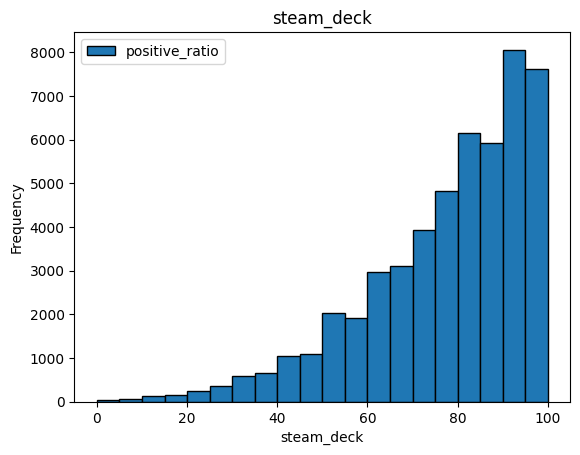

In [ ]:
games_df.select("positive_ratio").toPandas().plot(kind='hist', title=column, bins=20, edgecolor='black')
plt.xlabel(column)
plt.ylabel("Frequency")
plt.show()

from the graph positive ratio, it's right skewed, a good percentage of reviews are actually positive

it's interesting to know which games got the highest positive rate, or with the price_final

In [ ]:
top_positive_ratio_games = games_df.orderBy(desc("positive_ratio"))
top_positive_ratio_games.select("title", "positive_ratio").show(10, truncate=False)


+------------------------------------------------------------+--------------+
|title                                                       |positive_ratio|
+------------------------------------------------------------+--------------+
|Endless Monday: Dreams and Deadlines                        |100           |
|Monster Roadtrip Playable character - Hazel                 |100           |
|Captain of Industry - Supporter edition upgrade             |100           |
|Bunny e-Shop  The Art of the Game                           |100           |
|Our Life: Beginnings & Always - Baxter's Story              |100           |
|The House in Fata Morgana Original Soundtrack               |100           |
|Cassette Beasts: Original Soundtrack                        |100           |
|Dead In Vinland - The Vallhund                              |100           |
|Call of Duty®: Modern Warfare® II - Griffin: Pro Pack       |100           |
|Valkyrie Hat (or 'Buy Us Coffee') DLC for Secrets of Grindea|10

<img src="https://cdn.cloudflare.steamstatic.com/steam/apps/1967010/header.jpg?t=1658249117" width = 400px align="right"/>
<img src="https://cdn.cloudflare.steamstatic.com/steam/apps/2147630/header.jpg?t=1666413158" width = 400px align="right"/>
<img src="https://cdn.cloudflare.steamstatic.com/steam/apps/1111460/header.jpg?t=1703214421" width = 400px align="right"/>
<img src="https://cdn.cloudflare.steamstatic.com/steam/apps/896640/ss_941231d3bd5225fc52f616c41b5c0d3cd9cdb896.1920x1080.jpg?t=1686562050" width = 400px align="right"/>



Surprisengly, most of the games are actually silly and are not of good graphics and most of them are targeted to young kids, maybe that's why they chose to give postive rate

In [ ]:
top_positive_ratio_games = games_df.orderBy(desc("positive_ratio"))
top_positive_ratio_games.select("title", "positive_ratio", "price_final").show(10, truncate=False)


+------------------------------------------------------------+--------------+-----------+
|title                                                       |positive_ratio|price_final|
+------------------------------------------------------------+--------------+-----------+
|Endless Monday: Dreams and Deadlines                        |100           |9.99       |
|Monster Roadtrip Playable character - Hazel                 |100           |2.39       |
|Captain of Industry - Supporter edition upgrade             |100           |8.99       |
|Bunny e-Shop  The Art of the Game                           |100           |2.99       |
|Our Life: Beginnings & Always - Baxter's Story              |100           |4.99       |
|The House in Fata Morgana Original Soundtrack               |100           |11.99      |
|Cassette Beasts: Original Soundtrack                        |100           |9.99       |
|Dead In Vinland - The Vallhund                              |100           |1.99       |
|Call of D

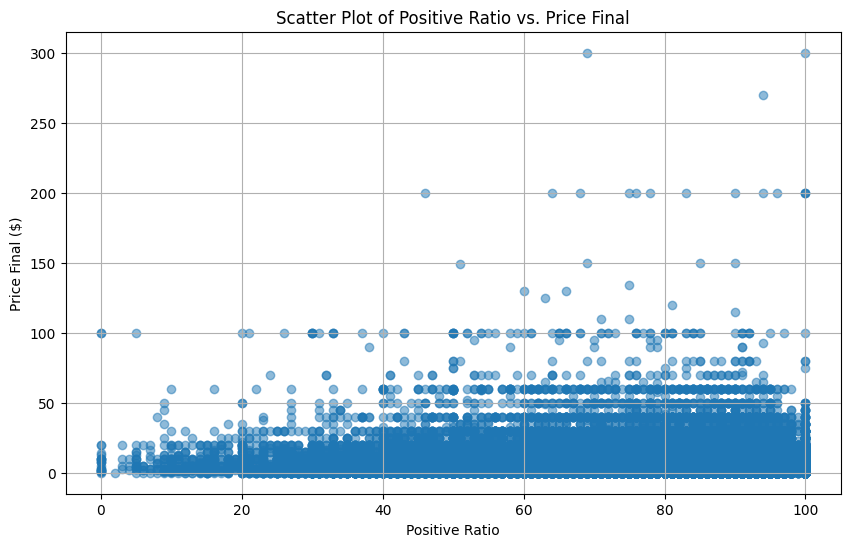

In [ ]:
top_positive_ratio_games = games_df.orderBy(desc("positive_ratio")).select("title", "positive_ratio", "price_final")
top_positive_ratio_pd = top_positive_ratio_games.toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(top_positive_ratio_pd["positive_ratio"], top_positive_ratio_pd["price_final"], alpha=0.5)
plt.title("Scatter Plot of Positive Ratio vs. Price Final")
plt.xlabel("Positive Ratio")
plt.ylabel("Price Final ($)")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql.functions import corr

# Calculate correlation between positive_ratio and price_final
correlation = games_df.select(corr("positive_ratio", "price_final")).collect()[0][0]

print(f"Correlation between positive_ratio and price_final: {correlation}")


Correlation between positive_ratio and price_final: -0.00998940957711038


seems like there is no correlation between them

**user_reviews**

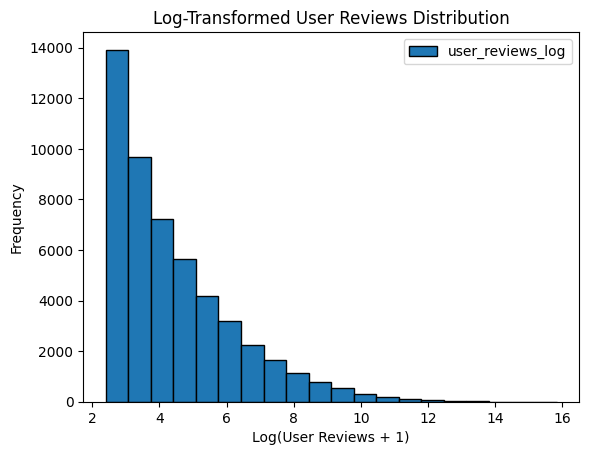

In [ ]:
games_df_log_transformed = games_df.withColumn("user_reviews_log", log(col("user_reviews") + 1))
games_df_log_transformed.select("user_reviews_log").toPandas().plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel("Log(User Reviews + 1)")
plt.ylabel("Frequency")
plt.title("Log-Transformed User Reviews Distribution")
plt.show()


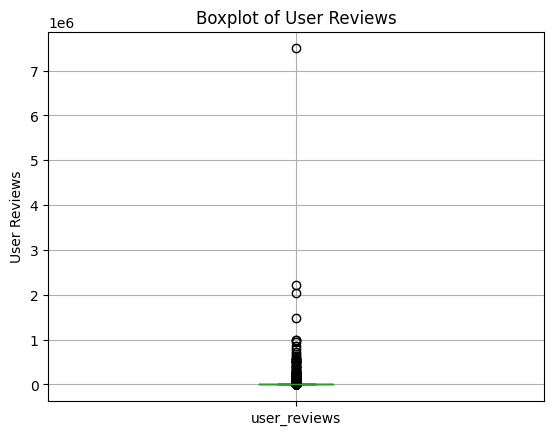

In [ ]:
games_df.select("user_reviews").toPandas().boxplot()
plt.title("Boxplot of User Reviews")
plt.ylabel("User Reviews")
plt.show()


**price_final**

Min= 0.0, Q1= 0.99, Median= 4.99, Q3= 10.99, Max= 299.99
Mean= 8.620324933161458


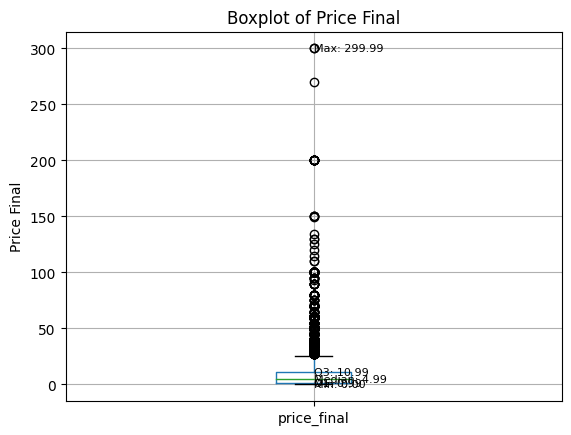

In [ ]:
q1, median, q3 = games_df.approxQuantile('price_final', [0.25, 0.5, 0.75], 0)
min_value, max_value = games_df.selectExpr("min(price_final)", "max(price_final)").first()

# print(f"Min= {min_value}, Q1= {q1}, Median= {median}, Q3= {q3}, Max = {max_value}")
mean_value = games_df.agg({'price_final': 'mean'}).collect()[0][0]
print(f"Min= {min_value}, Q1= {q1}, Median= {median}, Q3= {q3}, Max= {max_value}\nMean= {mean_value}")

plt.figure()
boxplot = games_df.select("price_final").toPandas().boxplot()
plt.title("Boxplot of Price Final")
plt.ylabel("Price Final")

plt.text(1, min_value, f'Min: {min_value:.2f}', verticalalignment='center', fontsize=8)
plt.text(1, q1, f'Q1: {q1:.2f}', verticalalignment='center', fontsize=8)
plt.text(1, median, f'Median: {median:.2f}', verticalalignment='center', fontsize=8)
plt.text(1, q3, f'Q3: {q3:.2f}', verticalalignment='center', fontsize=8)
plt.text(1, max_value, f'Max: {max_value:.2f}', verticalalignment='center', fontsize=8)

plt.show()


**Correlation**

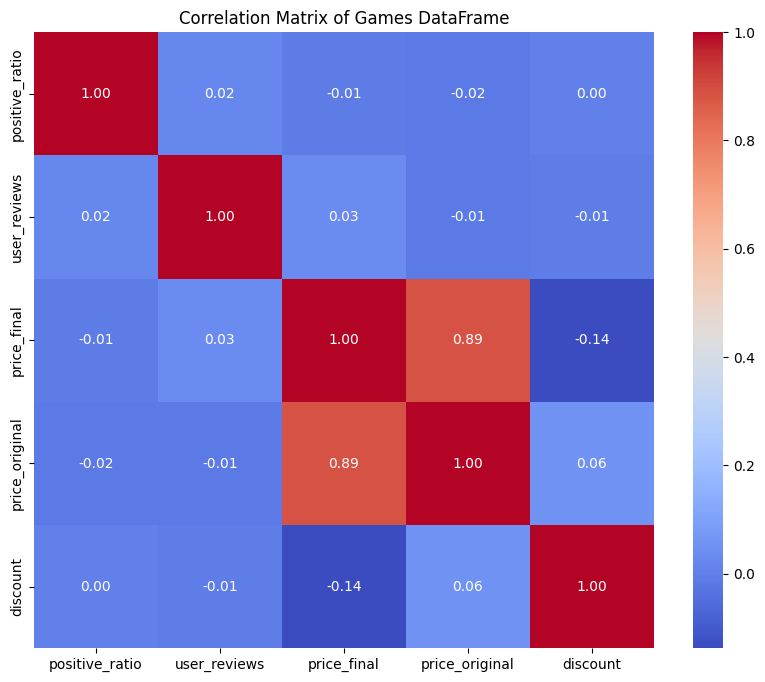

In [ ]:
numerical_columns = ["positive_ratio", "user_reviews", "price_final", "price_original", "discount"]
corr_matrix = pd.DataFrame(index=numerical_columns, columns=numerical_columns)
for col1 in numerical_columns:
    for col2 in numerical_columns:
        corr_value = games_df.select(corr(col1, col2)).collect()[0][0]
        corr_matrix.loc[col1, col2] = corr_value
corr_matrix = corr_matrix.apply(pd.to_numeric)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Games DataFrame")
plt.show()

## 3.2 users_df

In [ ]:
users_df.show()

+--------+--------+-------+
| user_id|products|reviews|
+--------+--------+-------+
| 7360263|     359|      0|
|14020781|     156|      1|
| 8762579|     329|      4|
| 4820647|     176|      4|
| 5167327|      98|      2|
| 5664667|     145|      5|
| 5889167|     447|      2|
| 7281762|    1083|      1|
| 7445952|     273|      1|
| 7462927|      51|      1|
| 7922733|     108|      2|
| 9201535|     166|      1|
| 9514331|     237|      4|
| 9972262|     250|      3|
|10184828|     187|      1|
|10714376|    1824|      2|
|11237958|      12|      1|
|11274058|     102|      4|
|11300174|     210|     17|
|11463309|     318|      5|
+--------+--------+-------+
only showing top 20 rows



In [ ]:
users_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- products: integer (nullable = true)
 |-- reviews: integer (nullable = true)



**reviews**: Number of reviews published

**products**: Number of games/add-ons purchased by the user

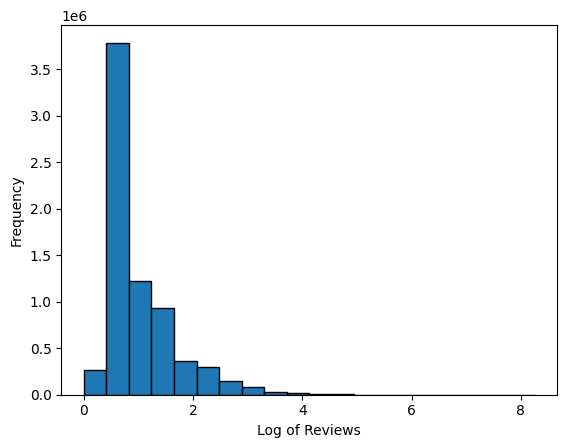

In [ ]:
sample_fraction = 0.5  # Adjust as needed
sample_df = users_df.sample(fraction=sample_fraction).toPandas()
sample_df['reviews_log'] = np.log(sample_df['reviews'] + 1)
sample_df['reviews_log'].plot(kind='hist', bins=20, edgecolor='black')
plt.xlabel("Log of Reviews")
plt.ylabel("Frequency")
plt.show()


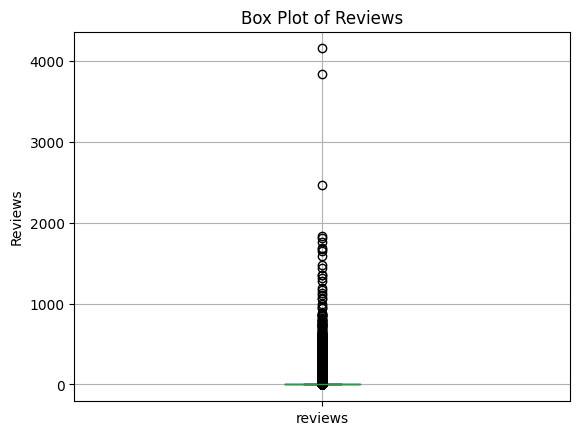

In [ ]:
sample_fraction = 0.5  # Adjust as needed
sample_df = users_df.sample(fraction=sample_fraction).toPandas()
plt.figure()
sample_df.boxplot(column=['reviews'])
plt.title("Box Plot of Reviews")
plt.ylabel("Reviews")
plt.show()


## 3.3 Rec df

In [ ]:
recommendation_df.show()

+-------+-------+-----+----------+--------------+-----+-------+---------+
| app_id|helpful|funny|      date|is_recommended|hours|user_id|review_id|
+-------+-------+-----+----------+--------------+-----+-------+---------+
| 975370|      0|    0|2022-12-12|          true| 36.3|  51580|        0|
| 304390|      4|    0|2017-02-17|         false| 11.5|   2586|        1|
|1085660|      2|    0|2019-11-17|          true|336.5| 253880|        2|
| 703080|      0|    0|2022-09-23|          true| 27.4| 259432|        3|
| 526870|      0|    0|2021-01-10|          true|  7.9|  23869|        4|
| 306130|      0|    0|2021-10-10|          true|  8.6|  45425|        5|
| 238960|      0|    0|2017-11-25|          true|538.8|  88282|        6|
|    730|      0|    0|2021-11-30|         false|157.5|  63209|        7|
| 255710|      0|    0|2021-05-21|          true| 18.7| 354512|        8|
| 289070|      0|    0|2020-05-26|          true|397.5| 454422|        9|
| 431960|      0|    0|2020-10-14|    

In [ ]:
recommendation_df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- review_id: integer (nullable = true)



# 4.0 Merging datasets and data cleaning


In [ ]:
games_df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)



In [ ]:
metadata_df.printSchema()

root
 |-- app_id: long (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
# from pyspark.sql.functions import col, desc

# # Joining the DataFrames on 'app_id'
# games_meta_df  = games_df.join(metadata_df, games_df.app_id == metadata_df.app_id, 'inner')
# games_meta_df.printSchema()

In [ ]:
from pyspark.sql.functions import col

# Joining the DataFrames on 'app_id' with alias for each DataFrame
games_meta_df = games_df.alias('games').join(metadata_df.alias('metadata'), col('games.app_id') == col('metadata.app_id'), 'inner')

# Selecting the columns you want
selected_columns = ['games.app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck', 'metadata.description', 'metadata.tags']

# Creating the final DataFrame with selected columns
games_meta_df = games_meta_df.select(*selected_columns)

games_meta_df.printSchema()


root
 |-- app_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
# Perform the join directly specifying the DataFrames
df = games_meta_df.join(recommendation_df, 'app_id', 'inner')

# Check the schema to ensure the join was successful
df.printSchema()


root
 |-- app_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- review_id: integer (nullable = true)



In [ ]:
# # Sample 10% of the recommendation DataFrame
# sampled_recommendation_df = recommendation_df.sample(False, 0.1)

# # Perform the join with the sampled DataFrame
# df = games_meta_df.join(sampled_recommendation_df, 'app_id', 'inner')

# # Check the schema to ensure the join was successful
# df.printSchema()


In [ ]:
print((df.count(), len(df.columns)))

(41154794, 22)


In [ ]:
df.show()

+------+-----------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-----+----------+--------------+-----+--------+---------+
|app_id|      title|date_release| win|  mac|linux|       rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|         description|                tags|helpful|funny|      date|is_recommended|hours| user_id|review_id|
+------+-----------+------------+----+-----+-----+-------------+--------------+------------+-----------+--------------+--------+----------+--------------------+--------------------+-------+-----+----------+--------------+-----+--------+---------+
|  1700|Arx Fatalis|  2007-04-03|true|false|false|Very Positive|            86|        1543|       4.99|          4.99|     0.0|      true|This critically a...|[RPG, First-Perso...|     14|    0|2018-01-25|          true| 85.5|11403380| 11205989|
|  1700|Arx 

In [ ]:
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- review_id: integer (nullable = true)



In [ ]:
# Drop specified columns
df = df.drop("review_id", "description", "title")
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- date_release: date (nullable = true)
 |-- win: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- rating: string (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: boolean (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)



In [ ]:
df.show(3)

+------+------------+----+----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+----------+--------------+-----+--------+
|app_id|date_release| win| mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                tags|helpful|funny|      date|is_recommended|hours| user_id|
+------+------------+----+----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+----------+--------------+-----+--------+
|  1500|  2012-04-24|true|true| true|Mostly Positive|            77|         664|       9.99|          9.99|     0.0|      true|[Retro, Atmospher...|      0|    0|2020-02-29|         false|  0.2| 6189977|
|  1500|  2012-04-24|true|true| true|Mostly Positive|            77|         664|       9.99|          9.99|     0.0|      true|[Retro, Atmospher...|      0|    0|2017-02-12|      

In [ ]:
from typing import Dict, List
from pyspark.sql import DataFrame
from pyspark.sql import functions as F


class PysparkOnehotEncoder:
    def __init__(self):
        self.conditions: Dict[str, Dict[str, int]] = {}
        self.categories: Dict[str, Dict[str, int]] = {}

    def fit(self, df: DataFrame, cat_cols: List[str]) -> None:
        for col in cat_cols:
            cats = df.select(col).distinct().collect()
            length = len(cats)
            cats: List[str] = [df.select(col).distinct().collect()[cat][0] for cat  in range(length)]

            self.conditions[col] = {}
            self.categories[col] = {}
            for idx, cat in enumerate(cats):
                self.conditions[col][f"{col} == '{cat}'"] = idx
                self.categories[col][cat] = idx # useful for reverse_transform at some point

    def predict(self, df: DataFrame) -> DataFrame:
        for col, cats_dict in self.categories.items():
            for cat, _idx in cats_dict.items():
                # Build the dynamic expression using F.when and F.otherwise
                expression = F.expr(f"CASE WHEN {col} == '{cat}' THEN 1 ELSE 0 END")

                # Apply the expression to the DataFrame
                df = df.withColumn(str(col) + "_" + str(cat), F.lit(0))
                df = df.withColumn(str(col) + "_" + str(cat), expression)
            df = df.drop(col)
        return df

    def fit_predict(self, df: DataFrame, cat_cols: List[str]):
        self.fit(df, cat_cols)
        df = self.predict(df)
        return df

In [ ]:
onehot_encoder_raing = PysparkOnehotEncoder()
onehot_encoder_raing.fit(df, ["rating"])

In [ ]:
df = onehot_encoder_raing.predict(df)

In [ ]:
df.show(3)

+------+------------+----+----+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+----------+--------------+-----+--------+----------------------+----------------------+--------------------+------------+---------------+------------------------------+--------------------+---------------+------------------------------+
|app_id|date_release| win| mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                tags|helpful|funny|      date|is_recommended|hours| user_id|rating_Mostly Negative|rating_Mostly Positive|rating_Very Positive|rating_Mixed|rating_Positive|rating_Overwhelmingly Positive|rating_Very Negative|rating_Negative|rating_Overwhelmingly Negative|
+------+------------+----+----+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+----------+--------------+-----+--------+----------------------+---------------------

In [ ]:
# Convert 'date_release' and 'date' to UNIX time
df = df.withColumn("date_release_unix", unix_timestamp("date_release"))
df = df.withColumn("date_unix", unix_timestamp("date"))

In [ ]:
df.show(3)

+------+------------+----+----+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+----------+--------------+-----+--------+----------------------+----------------------+--------------------+------------+---------------+------------------------------+--------------------+---------------+------------------------------+-----------------+----------+
|app_id|date_release| win| mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                tags|helpful|funny|      date|is_recommended|hours| user_id|rating_Mostly Negative|rating_Mostly Positive|rating_Very Positive|rating_Mixed|rating_Positive|rating_Overwhelmingly Positive|rating_Very Negative|rating_Negative|rating_Overwhelmingly Negative|date_release_unix| date_unix|
+------+------------+----+----+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+----------+--------------+-

In [ ]:
df = df.drop("date_release")

In [ ]:
df = df.drop("date")

In [ ]:
# Convert 'win', 'mac', 'linux', 'steam_deck' to integers (0 or 1)
boolean_columns = ['win', 'mac', 'linux', 'steam_deck']
for col_name in boolean_columns:
    df = df.withColumn(col_name, col(col_name).cast("integer"))
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: boolean (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Mostly Negative: integer (nullable = false)
 |-- rating_Mostly Positive: integer (nullable = false)
 |-- rating_Very Positive: integer (nullable = false)
 |-- rating_Mixed: integer (nullable = false)
 |-- rating_Positive: integer (nullable = false)
 |-- rating_Overwhelmingly Positive:

In [ ]:
df.show(3)

+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+--------------+-----+--------+----------------------+----------------------+--------------------+------------+---------------+------------------------------+--------------------+---------------+------------------------------+-----------------+----------+
|app_id|win|mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                tags|helpful|funny|is_recommended|hours| user_id|rating_Mostly Negative|rating_Mostly Positive|rating_Very Positive|rating_Mixed|rating_Positive|rating_Overwhelmingly Positive|rating_Very Negative|rating_Negative|rating_Overwhelmingly Negative|date_release_unix| date_unix|
+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+--------------+-----+--------+----------------------+----------------------+------------------

In [ ]:
boolean_columns = ['is_recommended']
for col_name in boolean_columns:
    df = df.withColumn(col_name, col(col_name).cast("integer"))
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: integer (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Mostly Negative: integer (nullable = false)
 |-- rating_Mostly Positive: integer (nullable = false)
 |-- rating_Very Positive: integer (nullable = false)
 |-- rating_Mixed: integer (nullable = false)
 |-- rating_Positive: integer (nullable = false)
 |-- rating_Overwhelmingly Positive:

In [ ]:
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: integer (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Mostly Negative: integer (nullable = false)
 |-- rating_Mostly Positive: integer (nullable = false)
 |-- rating_Very Positive: integer (nullable = false)
 |-- rating_Mixed: integer (nullable = false)
 |-- rating_Positive: integer (nullable = false)
 |-- rating_Overwhelmingly Positive:

In [ ]:
from pyspark.sql import functions as F

# Define the conditions for each rating
conditions = [
    (F.col("rating_Overwhelmingly Positive") == 1, 8),
    (F.col("rating_Very Positive") == 1, 7),
    (F.col("rating_Mostly Positive") == 1, 6),
    (F.col("rating_Positive") == 1, 5),
    (F.col("rating_Mixed") == 1, 4),
    (F.col("rating_Negative") == 1, 3),
    (F.col("rating_Mostly Negative") == 1, 2),
    (F.col("rating_Very Negative") == 1, 1),
    (F.col("rating_Overwhelmingly Negative") == 1, 0)
]

# Apply the conditions to create the new column
df = df.withColumn("rating_value", F.coalesce(*[F.when(cond, val) for cond, val in conditions]))

# Show the updated DataFrame schema
df.printSchema()


root
 |-- app_id: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: integer (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Mostly Negative: integer (nullable = false)
 |-- rating_Mostly Positive: integer (nullable = false)
 |-- rating_Very Positive: integer (nullable = false)
 |-- rating_Mixed: integer (nullable = false)
 |-- rating_Positive: integer (nullable = false)
 |-- rating_Overwhelmingly Positive:

In [ ]:
df_clean = df.drop("rating_Overwhelmingly Negative", "rating_Negative", "rating_Overwhelmingly Positive","rating_Positive","rating_Mixed", "rating_Very Positive","rating_Mostly Positive","rating_Mostly Negative")
df_clean.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: integer (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Very Negative: integer (nullable = false)
 |-- date_release_unix: long (nullable = true)
 |-- date_unix: long (nullable = true)
 |-- rating_value: integer (nullable = true)



In [ ]:
df_clean = df_clean.drop("tags")
df_clean.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: integer (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Very Negative: integer (nullable = false)
 |-- date_release_unix: long (nullable = true)
 |-- date_unix: long (nullable = true)
 |-- rating_value: integer (nullable = true)



In [ ]:
df_clean_ = df_clean.drop('app_id')
df_clean_.printSchema()

root
 |-- win: integer (nullable = true)
 |-- mac: integer (nullable = true)
 |-- linux: integer (nullable = true)
 |-- positive_ratio: integer (nullable = true)
 |-- user_reviews: integer (nullable = true)
 |-- price_final: double (nullable = true)
 |-- price_original: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- steam_deck: integer (nullable = true)
 |-- helpful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- is_recommended: integer (nullable = true)
 |-- hours: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating_Very Negative: integer (nullable = false)
 |-- date_release_unix: long (nullable = true)
 |-- date_unix: long (nullable = true)
 |-- rating_value: integer (nullable = true)



In [ ]:
df.show(3)

+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+--------------+-----+--------+----------------------+----------------------+--------------------+------------+---------------+------------------------------+--------------------+---------------+------------------------------+-----------------+----------+------------+
|app_id|win|mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                tags|helpful|funny|is_recommended|hours| user_id|rating_Mostly Negative|rating_Mostly Positive|rating_Very Positive|rating_Mixed|rating_Positive|rating_Overwhelmingly Positive|rating_Very Negative|rating_Negative|rating_Overwhelmingly Negative|date_release_unix| date_unix|rating_value|
+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+--------------+-----+--------+----------------------+---------------

In [ ]:
df_no_user_id = df.drop("user_id")
df_no_userid_movieid = df.drop("user_id","app_id")


# Joint Exploration

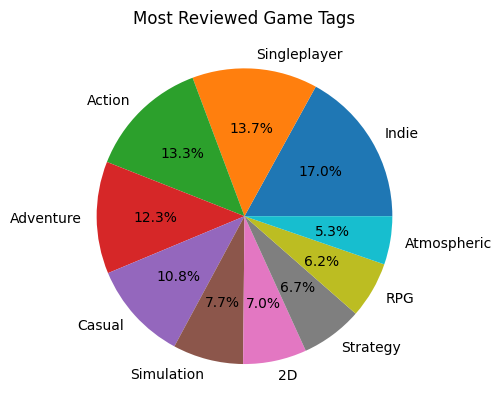

In [ ]:
exploded_df = games_meta_df.select("tags").withColumn("tag", explode(col("tags")))

# Count the occurrences of each tag
tag_counts = exploded_df.groupBy("tag").count().orderBy("count", ascending=False)

# Collect the data to the driver node for plotting
tag_counts_pd = tag_counts.limit(10).toPandas()

# Create a pie chart
fig, ax = plt.subplots()
plt.title('Most Reviewed Game Tags')
ax.pie(tag_counts_pd['count'], labels=tag_counts_pd['tag'], autopct='%1.1f%%')
plt.show()

Seems like the most reviewd type is indie, single player, actoin.

In [ ]:
games_df.show()

+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
|app_id|               title|date_release| win|  mac|linux|         rating|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|
+------+--------------------+------------+----+-----+-----+---------------+--------------+------------+-----------+--------------+--------+----------+
| 13500|Prince of Persia:...|  2008-11-21|true|false|false|  Very Positive|            84|        2199|       9.99|          9.99|     0.0|      true|
| 22364|BRINK: Agents of ...|  2011-08-03|true|false|false|       Positive|            85|          21|       2.99|          2.99|     0.0|      true|
|113020|Monaco: What's Yo...|  2013-04-24|true| true| true|  Very Positive|            92|        3722|      14.99|         14.99|     0.0|      true|
|226560|  Escape Dead Island|  2014-11-18|true|false|false|          Mixed|            61|    

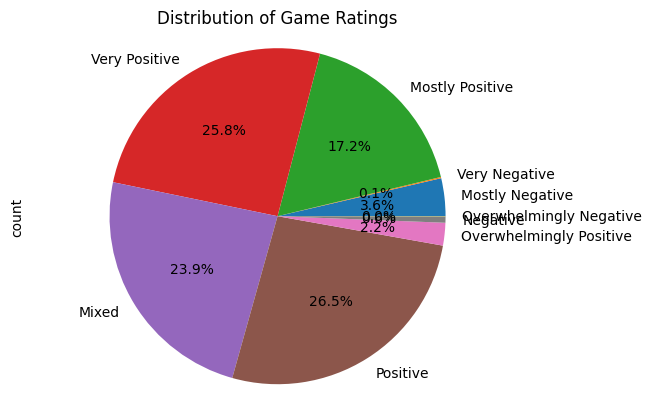

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Count the number of occurrences of each rating
count_ratings_df = games_df.groupBy("rating").count()

# Collect the data to the driver node for plotting
count_ratings_pd = count_ratings_df.toPandas()

# Visualization in a pie chart
count_ratings_pd.set_index("rating")['count'].plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Game Ratings')
plt.show()


seems like most of the review were very positive the mixed, then mostly positive

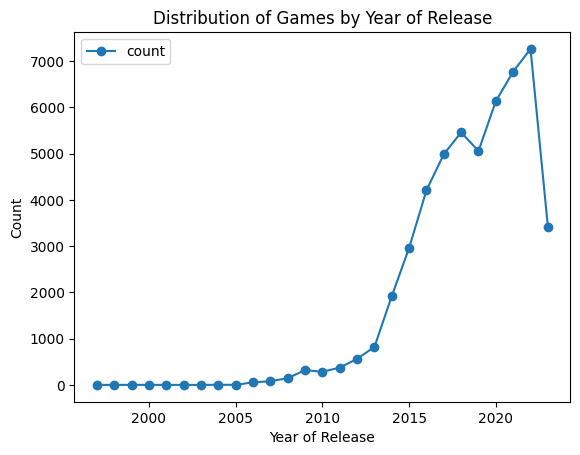

In [ ]:
from pyspark.sql.functions import year, col
import matplotlib.pyplot as plt

# Convert the release date column to datetime type
games_df = games_df.withColumn("date_release", col("date_release").cast("timestamp"))

# Counting games by year of release
count_release_year_df = games_df.groupBy(year("date_release").alias("year")).count().orderBy("year")

# Collect the data to the driver node for plotting
count_release_year_pd = count_release_year_df.toPandas()

# Visualization in a line chart
count_release_year_pd.plot(kind='line', x='year', y='count', marker='o')
plt.xlabel('Year of Release')
plt.ylabel('Count')
plt.title('Distribution of Games by Year of Release')
plt.show()


there were huge number of games producec in 2020

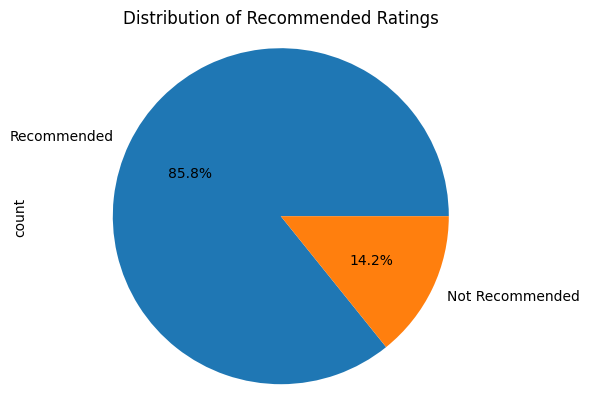

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Count the occurrences of recommended and not recommended values
recomendados_df = recommendation_df.groupBy("is_recommended").count()

# Collect the data to the driver node for plotting
recomendados_pd = recomendados_df.toPandas()

# Visualization in a pie chart
recomendados_pd.set_index("is_recommended")['count'].plot(kind='pie', autopct='%1.1f%%', labels=['Recommended', 'Not Recommended'])
plt.axis('equal')
plt.title('Distribution of Recommended Ratings')
plt.show()


data is not balanced

In [ ]:
df.show(5)

+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+--------------+-----+--------+----------------------+----------------------+--------------------+------------+---------------+------------------------------+--------------------+---------------+------------------------------+-----------------+----------+------------+
|app_id|win|mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|                tags|helpful|funny|is_recommended|hours| user_id|rating_Mostly Negative|rating_Mostly Positive|rating_Very Positive|rating_Mixed|rating_Positive|rating_Overwhelmingly Positive|rating_Very Negative|rating_Negative|rating_Overwhelmingly Negative|date_release_unix| date_unix|rating_value|
+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+--------------------+-------+-----+--------------+-----+--------+----------------------+---------------

In [ ]:
# column_names = df.columns

# # Drop the second occurrence of the column 'name'
# new_df = df.drop(column_names[column_names.index('app_id', column_names.index('app_id') + 1)])


In [ ]:
# selected_columns = df.select( "app_id"[0])

# 5.0 ALS model

In [ ]:
from pyspark.ml.recommendation import ALS
train_data, test_data = df_clean.randomSplit([0.8,0.2])
train_data_sample = train_data.sample(fraction=0.1, seed=42)


In [ ]:
als=ALS(userCol='user_id',itemCol='app_id',ratingCol='rating_value',nonnegative=True,coldStartStrategy='drop', rank =10)
model=als.fit(train_data_sample)
predictions=model.transform(test_data)

In [ ]:
test_data.show()

+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+-------+-----+--------------+-----+--------+--------------------+-----------------+----------+------------+
|app_id|win|mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|helpful|funny|is_recommended|hours| user_id|rating_Very Negative|date_release_unix| date_unix|rating_value|
+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+-------+-----+--------------+-----+--------+--------------------+-----------------+----------+------------+
|   240|  1|  1|    1|            96|      103720|       9.99|          9.99|     0.0|         1|      0|    0|             1| 17.1| 8410454|                   0|       1099267200|1669507200|           8|
|   240|  1|  1|    1|            96|      103720|       9.99|          9.99|     0.0|         1|      0|    0|             1| 17.7|14114625|                   0|       1099267200|

In [ ]:
train_data.show()

+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+-------+-----+--------------+-----+--------+--------------------+-----------------+----------+------------+
|app_id|win|mac|linux|positive_ratio|user_reviews|price_final|price_original|discount|steam_deck|helpful|funny|is_recommended|hours| user_id|rating_Very Negative|date_release_unix| date_unix|rating_value|
+------+---+---+-----+--------------+------------+-----------+--------------+--------+----------+-------+-----+--------------+-----+--------+--------------------+-----------------+----------+------------+
|   240|  1|  1|    1|            96|      103720|       9.99|          9.99|     0.0|         1|      0|    0|             1|  0.1| 2465369|                   0|       1099267200|1669161600|           8|
|   240|  1|  1|    1|            96|      103720|       9.99|          9.99|     0.0|         1|      0|    0|             1|  0.4| 9635973|                   0|       1099267200|

In [ ]:
user_id = 2465369
user_recs = model.recommendForUserSubset(spark.createDataFrame([[user_id]], ["user_id"]), numItems=5).collect()

# Check if recommendations are available for the user
if user_recs:
    recommendations = user_recs[0]['recommendations']
    print("Rec for user:")
    for rec in recommendations:
        print(rec)
else:
    print("No recommendations found for the user.")


No recommendations found for the user.


In [ ]:
user_ids = [2465369, 12326061, 1525203, 6283763, 11726448, 10454063, 3754721, 3214739]
all_user_recs = []

for user_id in user_ids:
    user_recs = model.recommendForUserSubset(spark.createDataFrame([[user_id]], ["user_id"]), numItems=5).collect()

    # Check if recommendations are available for the user
    if user_recs:
        recommendations = user_recs[0]['recommendations']
        all_user_recs.append({"user_id": user_id, "recommendations": recommendations})
    else:
        all_user_recs.append({"user_id": user_id, "recommendations": None})

# Print recommendations for all users
for user_rec in all_user_recs:
    print(f"Rec for user {user_rec['user_id']}:")
    if user_rec['recommendations']:
        for rec in user_rec['recommendations']:
            print(rec)
    else:
        print("No recommendations found for the user.")


Rec for user 2465369:
No recommendations found for the user.
Rec for user 12326061:
Row(app_id=1109130, rating=17.59348487854004)
Row(app_id=1552680, rating=16.858224868774414)
Row(app_id=1243130, rating=16.77493667602539)
Row(app_id=1701560, rating=16.772016525268555)
Row(app_id=1740850, rating=16.391664505004883)
Rec for user 1525203:
Row(app_id=1243130, rating=16.317975997924805)
Row(app_id=1422630, rating=15.465693473815918)
Row(app_id=1679220, rating=15.369559288024902)
Row(app_id=1646580, rating=14.985128402709961)
Row(app_id=1770390, rating=14.853643417358398)
Rec for user 6283763:
No recommendations found for the user.
Rec for user 11726448:
Row(app_id=1243130, rating=16.317975997924805)
Row(app_id=1422630, rating=15.465693473815918)
Row(app_id=1679220, rating=15.369559288024902)
Row(app_id=1646580, rating=14.985128402709961)
Row(app_id=1770390, rating=14.853643417358398)
Rec for user 10454063:
No recommendations found for the user.
Rec for user 3754721:
No recommendations foun

In [ ]:
for user_rec in all_user_recs:
    print(f"Rec for user {user_rec['user_id']}:")
    if user_rec['recommendations']:
        # Fetch game titles for each recommendation
        game_titles = [games_df.filter(games_df.app_id == rec['app_id']).select('title').collect()[0]['title'] for rec in user_rec['recommendations']]

        # Print the game titles
        for title in game_titles:
            print(title)
    else:
        print("No recommendations found for the user.")

Rec for user 2465369:
No recommendations found for the user.
Rec for user 12326061:
逝去的回忆3：四叶草之梦
Escape FishStop 3D
Nimbatus - Drone Creator
RUINSMAGUS
角斗士学院（Gladiator School）
Rec for user 1525203:
